# Best Model with Attention

In [56]:
# importing required libraries for the notebook
import lightning as lt
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
import os
import torch
import wandb
import torch.nn as nn
from IPython.display import display
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from torchaudio.functional import edit_distance as edit_dist
import random
from language import *
from dataset_dataloader import *
from encoder_decoder import *

In [4]:
# know the accelerator available - NOT USED as we have switched to lightning
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Defining the source and target languages and loading data

In [5]:
# define the source and target languages
TARGET = 'tam'
SOURCE = 'eng'

In [6]:
# load all the available data and print sample counts for each set
x_train, y_train = load_data(TARGET, 'train')
x_valid, y_valid = load_data(TARGET, 'valid')
x_test, y_test = load_data(TARGET, 'test')

print(f'Number of train samples = {len(x_train)}')
print(f'Number of valid samples = {len(x_valid)}')
print(f'Number of test samples = {len(x_test)}')

Number of train samples = 51200
Number of valid samples = 4096
Number of test samples = 4096


In [7]:
# create language objects for storing vocabulary, index2sym and sym2index
SRC_LANG = Language(SOURCE)
TAR_LANG = Language(TARGET)

# creating vocabulary using train data only
SRC_LANG.create_vocabulary(*(x_train))
TAR_LANG.create_vocabulary(*(y_train))

# generate mappings from characters to numbers and vice versa
SRC_LANG.generate_mappings()
TAR_LANG.generate_mappings()

# print the source and target vocabularies
print(f'Source Vocabulary Size = {len(SRC_LANG.symbols)}')
print(f'Source Vocabulary = {SRC_LANG.symbols}')
print(f'Source Mapping {SRC_LANG.index2sym}')
print(f'Target Vocabulary Size = {len(TAR_LANG.symbols)}')
print(f'Target Vocabulary = {TAR_LANG.symbols}')
print(f'Target Mapping {TAR_LANG.index2sym}')

Source Vocabulary Size = 26
Source Vocabulary = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Source Mapping {0: '@', 1: '$', 2: '!', 3: '%', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}
Target Vocabulary Size = 46
Target Vocabulary = ['ஃ', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'க', 'ங', 'ச', 'ஜ', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ஷ', 'ஸ', 'ஹ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', 'ௌ', '்']
Target Mapping {0: '@', 1: '$', 2: '!', 3: '%', 4: 'ஃ', 5: 'அ', 6: 'ஆ', 7: 'இ', 8: 'ஈ', 9: 'உ', 10: 'ஊ', 11: 'எ', 12: 'ஏ', 13: 'ஐ', 14: 'ஒ', 15: 'ஓ', 16: 'க', 17: 'ங', 18: 'ச', 19: 'ஜ', 20: 'ஞ', 21: 'ட', 22: 'ண', 23: 'த', 24: 'ந', 25: 'ன', 26: 'ப', 27: 'ம', 28: 'ய',

## Runner Class

In [8]:
'''
    Pytorch lightning based module that encapsulates our seq2seq model with useful
    helper functions
'''
class Runner(lt.LightningModule):
    def __init__(self, src_lang : Language, tar_lang : Language, common_embed_size, common_num_layers, 
                 common_hidden_size, common_cell_type, init_tf_ratio = 0.8, enc_bidirect=False, attention=False, dropout=0.0, 
                 opt_name='Adam', learning_rate=2e-3, batch_size=32):
    
        super(Runner,self).__init__()
        # save the language objects
        self.src_lang = src_lang
        self.tar_lang = tar_lang

        # create all the sub-networks and the main model
        self.encoder = EncoderNet(vocab_size=src_lang.get_size(), embed_size=common_embed_size,
                             num_layers=common_num_layers, hid_size=common_hidden_size,
                             cell_type=common_cell_type, bidirect=enc_bidirect, dropout=dropout)
        if attention:
            self.attention = True
            self.attn_layer = Attention(common_hidden_size, enc_bidirect)
        else:
            self.attention = False
            self.attn_layer = None
        
        self.decoder = DecoderNet(vocab_size=tar_lang.get_size(), embed_size=common_embed_size,
                             num_layers=common_num_layers, hid_size=common_hidden_size,
                             cell_type=common_cell_type, attention=attention, attn_layer=self.attn_layer,
                             enc_bidirect=enc_bidirect, dropout=dropout)
        
        self.model = EncoderDecoder(encoder=self.encoder, decoder=self.decoder, src_lang=src_lang, 
                                    tar_lang=tar_lang)

        # for determinism
        torch.manual_seed(42); torch.cuda.manual_seed(42); np.random.seed(42); random.seed(42)

        self.model.apply(self.init_weights) # initialize model weights
        self.batch_size = batch_size

        # optimizer for the model and loss function [that ignores locs where target = PAD token]
        self.loss_criterion = nn.CrossEntropyLoss(ignore_index=tar_lang.sym2index[PAD_SYM])
        self.opt_name = opt_name
        self.learning_rate = learning_rate

        # only adam is present in configure_optimizers as of now
        if (opt_name != 'Adam'):
            exit(-1)

        self.save_test_preds = False # true if we want to save test predictions and not clear them on test epoch end
        self.cur_tf_ratio = init_tf_ratio # the current epoch teacher forcing ratio
        self.min_tf_ratio = 0.01          # minimum allowed teacher forcing ratio

        # lists for tracking predictions/true words etc...
        self.pred_train_words = []; self.true_train_words = []
        self.pred_valid_words = []; self.true_valid_words = []
        self.test_X_words = []; self.pred_test_words = []; self.true_test_words = []
        self.attn_matrices = []  # used only when there is attention layer

        # lists for tracking losses
        self.train_losses = []
        self.valid_losses = []

        # dictionary for logging at end of val epoch
        self.wdb_logged_metrics = dict()

    def configure_optimizers(self):
        optimizer = None
        if self.opt_name == 'Adam':
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

    @staticmethod
    def init_weights(m):
        '''
        function to initialize the weights of the model parameters
        '''
        for name, param in m.named_parameters():
            if 'weight' in name:
                 nn.init.uniform_(param.data, -0.04, 0.04)
            else:
                nn.init.constant_(param.data, 0)
    
    @staticmethod
    def exact_accuracy(pred_words, tar_words):
        ''' 
        compute the accuracy using (predicted words, target words) and return it.
        exact word matching is used.
        '''
        assert(len(pred_words) == len(tar_words))
        count = 0
        for i in range(len(pred_words)):
            if pred_words[i] == tar_words[i]:
                count += 1
        return count / len(pred_words)
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def setup(self, stage=None):
        # load all the available data on all GPUs
        self.x_train, self.y_train = load_data(TARGET, 'train')
        self.x_valid, self.y_valid = load_data(TARGET, 'valid')
        self.x_test, self.y_test = load_data(TARGET, 'test')

    def train_dataloader(self):
        dataset = TransliterateDataset(self.x_train[:4096], self.y_train[:4096], src_lang=SRC_LANG, tar_lang=TAR_LANG)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, collate_fn=CollationFunction(SRC_LANG, TAR_LANG))
        return dataloader

    def val_dataloader(self):
        dataset = TransliterateDataset(self.x_valid, self.y_valid, src_lang=SRC_LANG, tar_lang=TAR_LANG)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, collate_fn=CollationFunction(SRC_LANG, TAR_LANG))
        return dataloader

    def test_dataloader(self):
        dataset = TransliterateDataset(self.x_test, self.y_test, src_lang=SRC_LANG, tar_lang=TAR_LANG)
        dataloader = DataLoader(dataset=dataset, batch_size=1, collate_fn=CollationFunction(SRC_LANG, TAR_LANG))
        # we do inference word by word. So, batch_size = 1
        return dataloader

    ####################
    # INTERFACE RELATED FUNCTIONS - NOTE -> beam decoding (and save top 3 preds);
    #                                       wandb sweeping stuff and model checkpointing;
    #                                       put all together
    ####################

    def training_step(self, train_batch, batch_idx):
        batch_X, batch_y, X_lens = train_batch
        # get the logits, preds for the current batch
        logits, preds = self.model(batch_X, batch_y, X_lens, tf_ratio=self.cur_tf_ratio)
        # ignore loss for the first time step
        targets = batch_y[:, 1:]; logits = logits[:, 1:, :]
        logits = logits.swapaxes(1, 2) # make class logits the second dimension as needed
        loss = self.loss_criterion(logits, targets)
        # for epoch-level metrics[accuracy], log all the required data
        self.true_train_words += self.tar_lang.convert_to_words(batch_y)
        self.pred_train_words += self.tar_lang.convert_to_words(preds)
        self.train_losses.append(loss) # to get train loss for epoch
        return loss
    
    def on_train_epoch_end(self):
        # for wandb logging
        self.wdb_logged_metrics['train_loss'] = torch.stack(self.train_losses).mean()
        self.wdb_logged_metrics['train_acc'] = self.exact_accuracy(self.pred_train_words, self.true_train_words)
        self.wdb_logged_metrics['tf_ratio'] = self.cur_tf_ratio
        self.wdb_logged_metrics['epoch'] = self.current_epoch
        # note that on train_epoch_end is actually executed after valid epoch; so we log onto wandb here
        if wandb.run is not None:
            wandb.log(self.wdb_logged_metrics)
        
        # for debug purposes
        print(self.wdb_logged_metrics)

        # for display bar
        self.log('train_loss', self.wdb_logged_metrics['train_loss'], on_epoch=True, prog_bar=True)
        self.log('train_acc', self.wdb_logged_metrics['train_acc'], on_epoch=True, prog_bar=True)
        self.pred_train_words.clear(); self.true_train_words.clear() # clear to save memory and for next epoch

        # for first 12 epochs, we dont change the tf ratio. Then we decrease it by 0.1 every epoch till
        # min_tf_ratio is reached. This is also logged.
        if (self.current_epoch >= 11):
            self.cur_tf_ratio -= 0.1
            self.cur_tf_ratio = max(self.cur_tf_ratio, self.min_tf_ratio)

    def validation_step(self, valid_batch, batch_idx):
        batch_X, batch_y, X_lens = valid_batch
        # get the logits, preds for the current batch
        logits, preds = self.model(batch_X, batch_y, X_lens) # no teacher forcing
        # ignore loss for the first time step
        targets = batch_y[:, 1:]; logits = logits[:, 1:, :]
        logits = logits.swapaxes(1, 2) # make class logits the second dimension as needed
        loss = self.loss_criterion(logits, targets)
        # for epoch-level metrics[accuracy], log all the required data
        self.true_valid_words += self.tar_lang.convert_to_words(batch_y)
        self.pred_valid_words += self.tar_lang.convert_to_words(preds)
        self.valid_losses.append(loss) # to get val loss for epoch
    
    def on_validation_epoch_end(self):
        # for wandb logging
        self.wdb_logged_metrics['val_loss'] = torch.stack(self.valid_losses).mean()
        self.wdb_logged_metrics['val_acc'] = self.exact_accuracy(self.true_valid_words, self.pred_valid_words)

        # for display bar
        self.log('val_loss', self.wdb_logged_metrics['val_loss'], on_epoch=True, prog_bar=True)
        self.log('val_acc', self.wdb_logged_metrics['val_acc'], on_epoch=True, prog_bar=True)

        self.true_valid_words.clear(); self.pred_valid_words.clear() # clear to free memory and for next epoch
    
    def test_step(self, test_batch, batch_idx):
        batch_X, batch_y, X_lens = test_batch
        logits, pred_word, attn_matrix = self.model.greedy_inference(batch_X, X_lens)
        # update all the global lists
        self.pred_test_words += pred_word
        self.true_test_words += self.tar_lang.convert_to_words(batch_y)
        self.test_X_words += self.src_lang.convert_to_words(batch_X)
        # if there is attention, update the attention list also
        if (self.attention):
            self.attn_matrices += [attn_matrix]
        # ignore loss for the first time step
        targets = batch_y[:, 1:]; logits = logits[1:, :]
        # we shrink the logits to the true decoded sequence length for loss computation alone
        true_dec_len = targets.size(1)
        logits = (logits[:true_dec_len, :]).swapaxes(0,1).unsqueeze(0)
        # squeeze and swapping of dimensions is to meet condition needed by nn.CrossEntopyLoss()
        loss = self.loss_criterion(logits, targets)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
    
    # will prevent clearing of global test lists on test epoch end
    def track_test_predictions(self):
        self.save_test_preds = True

    def on_test_epoch_end(self):
        self.log('test_acc', self.exact_accuracy(self.pred_test_words, self.true_test_words), 
                 on_epoch=True, prog_bar=True)
        if not self.save_test_preds:
            self.pred_test_words.clear(); self.true_test_words.clear(); self.test_X_words.clear()
            self.attn_matrices.clear()
    
    # here, we will save all the predictions made and also, return a copy of the list of attention
    # matrices for generating heatmaps
    def save_test_predictions(self, fname='pred'):
        edit_distances = [edit_dist(pred,tar) for pred, tar in zip(self.pred_test_words,self.true_test_words)]
        pred_df = pd.DataFrame(zip(self.test_X_words, self.true_test_words, self.pred_test_words, edit_distances),
                               columns=['Input', 'Target', 'Predicted', 'Levenshtein Distance'])
        pred_df.to_csv('./'+fname+'.csv', index=False, encoding='utf-8')

        # if attention layer is present, we return attention matrices as well.
        ret_info = None
        if self.attention:
            ret_info = (self.test_X_words.copy(), self.true_test_words.copy(), self.pred_test_words.copy(), self.attn_matrices.copy())
        self.save_test_preds = False

        # clear after saving to save memory 
        self.pred_test_words.clear(); self.true_test_words.clear(); self.test_X_words.clear()
        self.attn_matrices.clear()
        return ret_info

# Attention Plotting Code

In [60]:
# run in a local system - need to figure out a font that supports tamil
from fontTools.ttLib import TTFont
import matplotlib.font_manager as mfm

def char_in_font(Unicode_char, font):
    for cmap in font['cmap'].tables:
        if cmap.isUnicode():
            if ord(Unicode_char) in cmap.cmap:
                return True
    return False

uni_char =  u"ப"
# or uni_char = u"\u2739"

font_info = [(f.fname, f.name) for f in mfm.fontManager.ttflist]

for i, font in enumerate(font_info):
    if char_in_font(uni_char, TTFont(font[0], fontNumber=0)):
        print(font[0], font[1])

/usr/share/fonts/truetype/freefont/FreeSerif.ttf FreeSerif
/usr/share/fonts/truetype/samyak-fonts/Samyak-Tamil.ttf Samyak Tamil
/usr/share/fonts/truetype/lohit-tamil/Lohit-Tamil.ttf Lohit Tamil
/usr/share/fonts/truetype/lohit-tamil-classical/Lohit-Tamil-Classical.ttf Lohit Tamil Classical


In [102]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
%matplotlib inline
font_path = '/usr/share/fonts/truetype/freefont/FreeSerif.ttf'
prop1 = mfm.FontProperties(fname=font_path) # find this font

font_path = '/usr/share/fonts/truetype/lohit-tamil/Lohit-Tamil.ttf'
prop2 = mfm.FontProperties(fname=font_path) # find this font

def generate_attention_heatmap(number, X_word, tar_word, pred_word, attn_matrix :torch.Tensor):
    # let <S> = <SOS> and <E> = <EOS>
    x_labels = list(pred_word) + ['<E>']
    y_labels = ['<S>'] + list(X_word) + ['<E>']
    # we ignore the 0th timestep as it was not generated by attn_layer
    # remember we did not stop inference when <EOS> was predicted. so, now we need
    # take the relevant entries from the attn matrix now.
    attn_matrix = np.transpose(attn_matrix[1:(len(x_labels) + 1),:].cpu().numpy())
    assert(len(x_labels) == attn_matrix.shape[1])
    assert(len(y_labels) == attn_matrix.shape[0])
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(attn_matrix, cmap='gray')
    fig.colorbar(im)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(attn_matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(attn_matrix.shape[0]), minor=False)

    # want a more natural, table-like display
    ax.xaxis.tick_top()
    ax.set_xticklabels(x_labels, minor=False, fontproperties=prop1)
    ax.set_yticklabels(y_labels, minor=False, fontproperties=prop1)
    ax.set_title(f'Src : {X_word}   Truth : {tar_word}   Pred : {pred_word}',fontproperties=prop1)
    plt.show()
    # log both the confusion matrix from wandb.plot and plotly plot along with loss, acc
    # wandb.log({f"Attention Plot {number}" :  fig})

In [99]:

pred = 'பிறந்தன'
source =  'pirandhana'
print(len(source), len(pred))
attn_matrix = torch.tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0756, 0.0756, 0.0767, 0.0916,
         0.1025, 0.1006, 0.1031],
        [0.0186, 0.0980, 0.4032, 0.3294, 0.0468, 0.0226, 0.0208, 0.0206, 0.0206,
         0.0108, 0.0040, 0.0046],
        [0.0163, 0.1227, 0.3652, 0.3500, 0.0633, 0.0203, 0.0173, 0.0169, 0.0169,
         0.0046, 0.0032, 0.0033],
        [0.0086, 0.0646, 0.2115, 0.3661, 0.1559, 0.0861, 0.0515, 0.0235, 0.0203,
         0.0040, 0.0038, 0.0039],
        [0.0042, 0.0213, 0.0267, 0.0310, 0.2111, 0.2560, 0.1445, 0.1291, 0.1035,
         0.0242, 0.0242, 0.0242],
        [0.0084, 0.0275, 0.0382, 0.0383, 0.0393, 0.1508, 0.2089, 0.2524, 0.0780,
         0.0528, 0.0526, 0.0526],
        [0.0144, 0.0158, 0.0210, 0.0202, 0.0362, 0.0983, 0.1638, 0.2683, 0.0921,
         0.0900, 0.0899, 0.0899],
        [0.0305, 0.0306, 0.0307, 0.0302, 0.0307, 0.0323, 0.0332, 0.0394, 0.1741,
         0.1926, 0.1901, 0.1856],
        [0.0462, 0.0466, 0.0466, 0.0450, 0.0466, 0.0468, 0.0469, 0.0476, 0.0671,
         0.2285, 0.2364, 0.0957],
        [0.0518, 0.0524, 0.0523, 0.0505, 0.0523, 0.0524, 0.0525, 0.0529, 0.0630,
         0.1997, 0.2407, 0.0795],
        [0.0522, 0.0528, 0.0528, 0.0509, 0.0528, 0.0529, 0.0529, 0.0533, 0.0627,
         0.1965, 0.2417, 0.0785],
        [0.0531, 0.0537, 0.0537, 0.0517, 0.0537, 0.0538, 0.0538, 0.0541, 0.0623,
         0.1901, 0.2433, 0.0766],
        [0.0539, 0.0545, 0.0545, 0.0525, 0.0545, 0.0546, 0.0546, 0.0549, 0.0621,
         0.1841, 0.2445, 0.0752],
        [0.0545, 0.0552, 0.0551, 0.0531, 0.0551, 0.0552, 0.0553, 0.0555, 0.0621,
         0.1791, 0.2454, 0.0743],
        [0.0550, 0.0556, 0.0556, 0.0535, 0.0556, 0.0557, 0.0557, 0.0560, 0.0621,
         0.1756, 0.2460, 0.0737],
        [0.0553, 0.0559, 0.0559, 0.0538, 0.0559, 0.0560, 0.0560, 0.0563, 0.0621,
         0.1732, 0.2463, 0.0733],
        [0.0555, 0.0561, 0.0561, 0.0540, 0.0561, 0.0562, 0.0562, 0.0565, 0.0622,
         0.1716, 0.2466, 0.0731],
        [0.0556, 0.0563, 0.0562, 0.0541, 0.0562, 0.0563, 0.0564, 0.0566, 0.0622,
         0.1706, 0.2467, 0.0729],
        [0.0557, 0.0564, 0.0563, 0.0542, 0.0563, 0.0564, 0.0565, 0.0567, 0.0622,
         0.1699, 0.2468, 0.0729],
        [0.0557, 0.0564, 0.0563, 0.0542, 0.0563, 0.0565, 0.0565, 0.0567, 0.0622,
         0.1695, 0.2468, 0.0728],
        [0.0557, 0.0564, 0.0564, 0.0542, 0.0564, 0.0565, 0.0565, 0.0568, 0.0622,
         0.1692, 0.2468, 0.0728],
        [0.0558, 0.0565, 0.0564, 0.0543, 0.0564, 0.0565, 0.0566, 0.0568, 0.0622,
         0.1690, 0.2469, 0.0728],
        [0.0558, 0.0565, 0.0564, 0.0543, 0.0564, 0.0565, 0.0566, 0.0568, 0.0622,
         0.1689, 0.2469, 0.0727],
        [0.0558, 0.0565, 0.0564, 0.0543, 0.0564, 0.0565, 0.0566, 0.0568, 0.0622,
         0.1689, 0.2469, 0.0727]])
print(attn_matrix.shape)

10 7
torch.Size([25, 12])


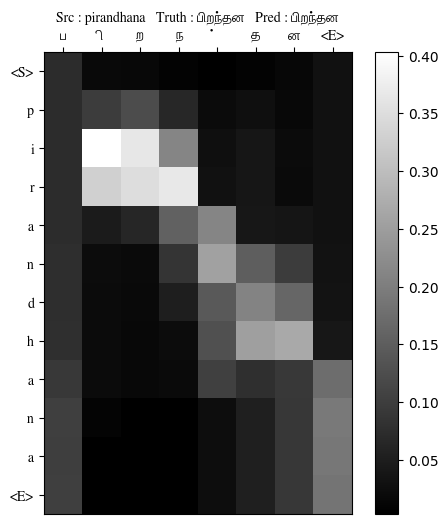

In [103]:
generate_attention_heatmap(1, source, pred, pred, attn_matrix)